# Класификация персонажей из Симпсонов



In [ ]:
#Максим Карпук
#импорт базовых необходимых библиотек
import torch
import numpy as np
# from google.colab import drive
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
# DEVICE=torch.device("cuda")

In [ ]:
DEVICE=torch.device("cuda")

In [ ]:
#проверка версии
import PIL
print(PIL.__version__)

11.0.0


In [ ]:
# #проверка доступа к GPU
# if not torch.cuda.is_available():
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     DEVICE = torch.device("cuda")
#     print('CUDA is available!  Training on GPU ...')
# !nvidia-smi
# import torch
# torch.cuda.is_available()

In [ ]:
# drive.mount('/content/gdrive/')#/content/gdrive/MyDrive/journey-springfield.zip
# !unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
# !ls train

In [ ]:
# оздание класса для динамической загрузки изображений
from collections import Counter
import pandas as pd
class ImagLoaderTranslateTorch(Dataset):
    def __init__(self, files, mode, RESCALE_SIZE=224):
        super().__init__()
        self.files = sorted(files)
        self.size=RESCALE_SIZE

        self.mode=mode
        if self.mode not in ['train', 'val', 'test']:
                print(f"{self.mode} is not correct; correct modes: 'train', 'val', 'test'")
                raise NameError

        # устранение проблемы несбалансированности классов путем дублирования изображений и в последующем их преобразований
        if self.mode=="train":
            class_counts = Counter([path.parent.name for path in self.files])
            self.minority_classes = [cls for cls in class_counts if class_counts[cls] < 100]
            dataset_dict = {x : [] for x in self.minority_classes}
            for i in self.files:
                if i.parent.name in  self.minority_classes:
                    dataset_dict[i.parent.name] += [i]
            for image in self.minority_classes:
                dataset_dict[image] = dataset_dict[image] * (100 // len(dataset_dict[image]))
                dataset_dict[image].extend(dataset_dict[image][:100 - len(dataset_dict[image])])
            for label in dataset_dict:
                self.files += dataset_dict[label]
            self.files = sorted(self.files)

        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

        self.len_ = len(self.files)


    def get_class_distribution(self):
        if self.mode == 'test':
            return "No labels in test mode"

        class_counts = Counter(self.labels)
        return pd.DataFrame({
            'Class': list(class_counts.keys()),
            'Count': list(class_counts.values())
        })
    def num_class(self):
        return len(np.unique([path.parent.name for path in self.files]))

    def __len__(self):
      return self.len_

    def load_sample(self, file):
      image = Image.open(file)
      image.load()
      return image

    def _prepare_sample(self, image):
      image = image.resize((self.size, self.size))
      # return np.array(image)
      return image

    def __getitem__(self, index):
      # для преобразования изображений в тензоры PyTorch и нормализации входа
      if self.mode=="train":
          # преобразования для продублированных картинок
         if self.labels[index] in self.minority_classes:
              transform = transforms.Compose([
                    transforms.RandomResizedCrop(self.size),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(30),      # случайный поворот на ±30 градусов
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # изменение цвета
                    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),     # случайное смещение и масштабирование
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # нормализация для ImageNet
                ])
         else:
             transform = transforms.Compose([
                transforms.Resize(256),
                transforms.RandomResizedCrop(self.size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(self.size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
      x = self.load_sample(self.files[index])
      # x = self._prepare_sample(x)
      # x = np.array(x / 255, dtype='float32')
      x = transform(x)
      if self.mode == 'test':
          return x
      else:
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y

    def imshow(self, title=None, number_characters=1000, plt_ax=plt, default=False):
      """Imshow для тензоров"""
      inp, label = self[number_characters]
      inp = inp.data.cpu().numpy().transpose((1, 2, 0))
      title=" ".join(map(lambda x: x.capitalize(),val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt_ax.imshow(inp)
      if title is not None:
          plt_ax.set_title(title)
      plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = ImagLoaderTranslateTorch(val_files, mode='val')

In [ ]:
val_dataset.num_class()

42

In [ ]:
train_dataset = ImagLoaderTranslateTorch(train_files, mode='train')
train_dataset.get_class_distribution().sort_values(by="Count", ascending=True)

,Class,Count
19,lionel_hutz,102
10,disco_stu,106
40,troy_mcclure,106
26,miss_hoover,113
13,gil,120
12,fat_tony,120
30,otto_mann,124
38,sideshow_mel,130
1,agnes_skinner,132
34,rainier_wolfcastle,134


# Проверка случайных картинок


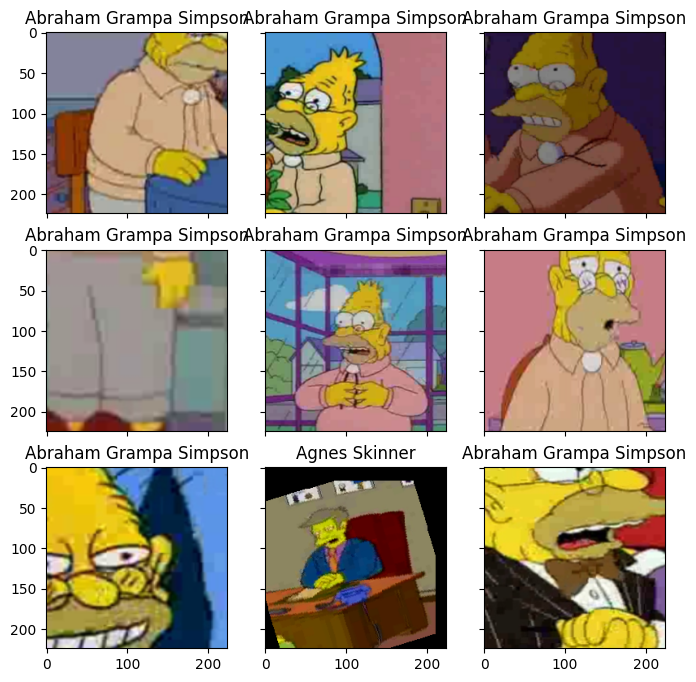

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                         sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.randint(0,1000))
    train_dataset.imshow(number_characters=random_characters,plt_ax=fig_x)

In [ ]:
len(train_dataset)

17799

# Построение нейросетей


In [ ]:
!pip install -q torchvision catalyst
import torchvision
from torchvision import datasets, models, transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00
Requested catalyst from https://files.pythonhosted.org/packages/05/09/36a4acd1c3112f2e2da74f4340778100a205ecb59166be00dc6287f3364f/catalyst-22.4-py2.py3-none-any.whl has invalid metadata: Expected matching RIGHT_PARENTHESIS for LEFT_PARENTHESIS, after version specifier
    scikit-image (<0.19.0>=0.16.1) ; extra == 'all'
                 ~~~~~~~~^
Please use pip<24.1 if you need to use this version.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.8 MB/s eta 0:00:00
Requested catalyst from https://files.pythonhosted.org/packages/28/4f/380899b95b45f02182e7163b4e9be4749724c898886d70009168bfd07409/catalyst-22.2.1-py2.py3-none-any.whl has invalid metadata: Expected matching RIGHT_PARENTHESIS for LEFT_PARENTHESIS, after version specifier
    scikit-image (<0.19.0>=0.16.1) ; extra == 'all'
                 ~~~~~~~~^
Please use pip<24.1 if you need to use this version.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# class SimpsonVGG16(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.backbone = models.vgg16(weights="DEFAULT").to(DEVICE)

#         # Замораживаем все слои, кроме последнего
#         for param in self.backbone.features[20:].parameters():
#           param.requires_grad = False

#         # Заменяем последний полносвязный слой
#         in_features = self.backbone.classifier[6].in_features
#         self.backbone.classifier[6] = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.backbone(x)

In [ ]:
# model=models.resnet152(weights="DEFAULT").to(DEVICE)
# model

In [ ]:
class SimpsonResNet152(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT").to(DEVICE)

        # Замораживаем все слои, кроме последнего
        for name, param in self.backbone.named_parameters():
            if "layer4" not in name:
                param.requires_grad = False


        # Заменяем последний полносвязный слой
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# # num_features -- это размерность вектора фич, поступающего на вход FC-слою
# num_features = 4096
# # Заменяем Fully-Connected слой на наш линейный классификатор
# model.classifier[6] = nn.Linear(num_features, 42)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# # очистка кэша инструмента динамической визуализации и его подключение
# !rm -rf logs
# %reload_ext tensorboard
# %tensorboard --logdir logs

# Функции для обучения cnn



In [ ]:
# Макет переменной в которой будем сохранять стадии обучения
#checkpoint = {
#     'epoch': epoch,  # количество выполненных эпох
#     'model_state_dict': modelVGG.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss_train': train_loss,  # значение функции потерь
#     'val_loss' : val_loss
# }
# torch.save(checkpoint, 'pitstop.pth')

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
from tqdm import tqdm
import os
import torch.optim as optim
from IPython.display import FileLink

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
    retraining=False
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        scheduler = optim.lr_scheduler.StepLR(opt, 2, gamma=0.5)
        criterion = nn.CrossEntropyLoss()
        if os.access('/kaggle/working/pitstop_resnet1522.pth', os.X_OK):
            checkpoint = torch.load('/kaggle/working/pitstop_resnet1522.pth')
            start_epoch=checkpoint['epoch']
            model.load_state_dict(checkpoint['model_state_dict'])
            opt.load_state_dict(checkpoint['optimizer_state_dict'])
        else:
            checkpoint = {
                  'epoch': 0,
                  'model_state_dict': 0,
                  'optimizer_state_dict': 0,
                  'history_loss': ([0],[0],[0],[0])
                  }
            start_epoch=checkpoint['epoch']

        for epoch in range(start_epoch, epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if retraining==False:
              if ((checkpoint['history_loss'])[-1])[-1]*0.95>val_acc:
                retraining=True
              else:
                checkpoint = {
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': opt.state_dict(),
                  'history_loss': history
                }
                torch.save(checkpoint, '/kaggle/working/pitstop_resnet1522.pth')
                FileLink('/kaggle/working/pitstop_resnet1522.pth')
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Распознавание одной реальной картинки

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.unsqueeze(0)
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
def predict_one_real_sample(model, inputs_path, device=DEVICE):
    TEST1_DIR = Path(inputs_path)
    test1_files = sorted(list(TEST1_DIR.rglob('*.jpg')))
    data=ImagLoaderTranslateTorch(test1_files, mode='test')
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    pred = label_encoder.inverse_transform(np.argmax(predict_one_sample(model, data[0], device=DEVICE), axis=1))
    predicted_proba = np.max(predict_one_sample(model, data[0], device=DEVICE))*100
    print("ТЫ -",*pred," с вероятностью ",predicted_proba,"%")


In [ ]:
# model=SimpsonResNet152(num_classes=val_dataset.num_class()).to(DEVICE)
# checkpoint = torch.load('/kaggle/input/wightresnet/pitstop_resnet.pth')
# model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# predict_one_real_sample(model, inputs_path="/kaggle/input/pasha-simpson3")

# Обучение и тестирование модели


In [ ]:
model=SimpsonResNet152(num_classes=val_dataset.num_class()).to(DEVICE)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


SimpsonResNet152(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [ ]:
if val_dataset is None:
    val_dataset = ImagLoaderTranslateTorch(val_files, mode='val')

if train_dataset is None:
    train_dataset = ImagLoaderTranslateTorch(train_files, mode='train')
history = train(train_dataset, val_dataset, model=model, epochs=13, batch_size=64)

epoch:   0%|          | 0/13 [00:00<?, ?it/s]

loss 1.170161275366289


epoch:   8%|▊         | 1/13 [06:45<1:21:00, 405.06s/it]


Epoch 001 train_loss: 1.1702     val_loss 0.4297 train_acc 0.6807 val_acc 0.9049
loss 0.7966363512067903


epoch:  15%|█▌        | 2/13 [11:05<58:40, 320.00s/it]  


Epoch 002 train_loss: 0.7966     val_loss 0.3974 train_acc 0.7771 val_acc 0.8917
loss 0.6307352549460866


epoch:  23%|██▎       | 3/13 [15:23<48:34, 291.50s/it]


Epoch 003 train_loss: 0.6307     val_loss 0.3678 train_acc 0.8213 val_acc 0.9094
loss 0.5395395394402733


epoch:  31%|███       | 4/13 [19:36<41:28, 276.50s/it]


Epoch 004 train_loss: 0.5395     val_loss 0.3095 train_acc 0.8497 val_acc 0.9257
loss 0.48424124407616886


epoch:  38%|███▊      | 5/13 [23:52<35:51, 268.90s/it]


Epoch 005 train_loss: 0.4842     val_loss 0.2564 train_acc 0.8607 val_acc 0.9383
loss 0.46309511809143045


epoch:  46%|████▌     | 6/13 [27:50<30:09, 258.51s/it]


Epoch 006 train_loss: 0.4631     val_loss 0.2729 train_acc 0.8679 val_acc 0.9377
loss 0.42954516897403


epoch:  54%|█████▍    | 7/13 [31:50<25:14, 252.48s/it]


Epoch 007 train_loss: 0.4295     val_loss 0.2393 train_acc 0.8771 val_acc 0.9459
loss 0.4145241874149324


epoch:  62%|██████▏   | 8/13 [35:49<20:40, 248.05s/it]


Epoch 008 train_loss: 0.4145     val_loss 0.2273 train_acc 0.8833 val_acc 0.9452
loss 0.40416675803837443


epoch:  69%|██████▉   | 9/13 [39:49<16:22, 245.63s/it]


Epoch 009 train_loss: 0.4042     val_loss 0.2160 train_acc 0.8872 val_acc 0.9524
loss 0.3834803716152784


epoch:  77%|███████▋  | 10/13 [43:53<12:15, 245.12s/it]


Epoch 010 train_loss: 0.3835     val_loss 0.2826 train_acc 0.8920 val_acc 0.9404
loss 0.37567746388764184


epoch:  85%|████████▍ | 11/13 [47:57<08:09, 244.70s/it]


Epoch 011 train_loss: 0.3757     val_loss 0.2217 train_acc 0.8940 val_acc 0.9496
loss 0.3541425920169376


epoch:  92%|█████████▏| 12/13 [52:00<04:04, 244.28s/it]


Epoch 012 train_loss: 0.3541     val_loss 0.2075 train_acc 0.8973 val_acc 0.9547
loss 0.3317173159459353


epoch: 100%|██████████| 13/13 [56:01<00:00, 243.31s/it]


Epoch 013 train_loss: 0.3317     val_loss 0.2160 train_acc 0.9084 val_acc 0.9553


epoch: 100%|██████████| 13/13 [56:01<00:00, 258.61s/it]


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

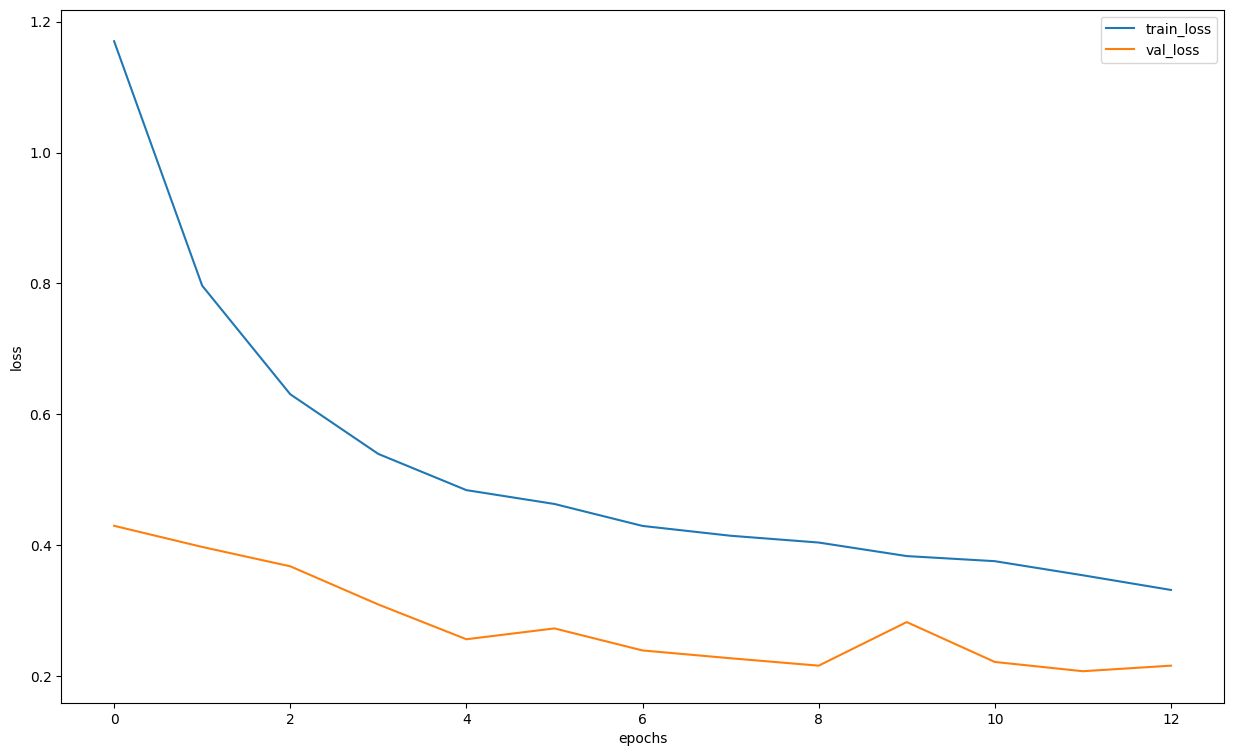

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
checkpoint = torch.load('pitstop_resnet1522.pth')
checkpoint['epoch']

<ipython-input-36-df6f635cfe64>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('pitstop_resnet1522.pth')


12

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9500000000000001


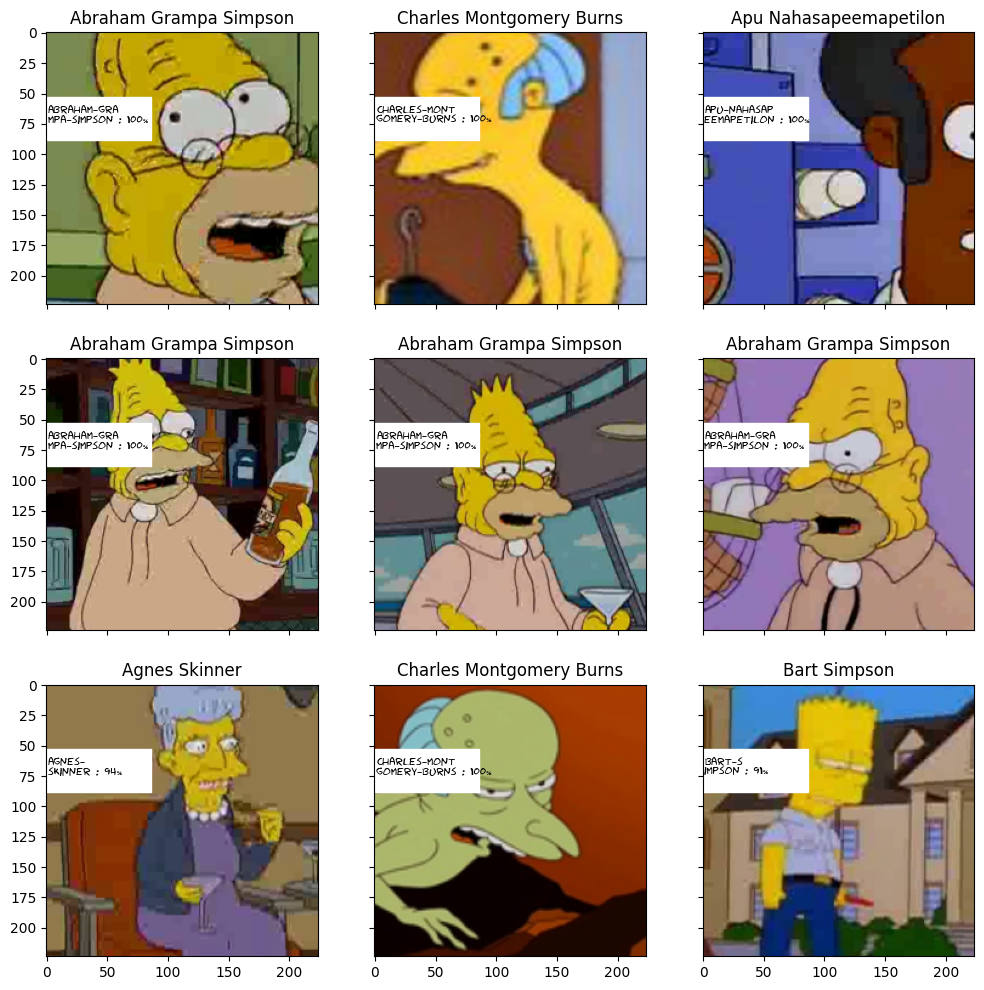

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    val_dataset.imshow(title=img_label, number_characters=random_characters ,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val)
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
#дообучение модели на валидационных данных
train_dataset = ImagLoaderTranslateTorch(val_files, mode='train')

In [ ]:
history+=train(train_dataset, val_dataset, model=model, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.5606871081286386


epoch:  20%|██        | 1/5 [02:13<08:53, 133.32s/it]


Epoch 001 train_loss: 0.5607     val_loss 0.1230 train_acc 0.8508 val_acc 0.9698
loss 0.43441456891567415


epoch:  40%|████      | 2/5 [04:26<06:39, 133.17s/it]


Epoch 002 train_loss: 0.4344     val_loss 0.1081 train_acc 0.8812 val_acc 0.9733
loss 0.38776982094941287


epoch:  60%|██████    | 3/5 [06:39<04:26, 133.08s/it]


Epoch 003 train_loss: 0.3878     val_loss 0.1218 train_acc 0.8902 val_acc 0.9704
loss 0.3663813542388717


epoch:  80%|████████  | 4/5 [08:52<02:13, 133.14s/it]


Epoch 004 train_loss: 0.3664     val_loss 0.1070 train_acc 0.8919 val_acc 0.9727
loss 0.3667746300009261


epoch: 100%|██████████| 5/5 [11:05<00:00, 133.01s/it]


Epoch 005 train_loss: 0.3668     val_loss 0.0898 train_acc 0.8963 val_acc 0.9765


epoch: 100%|██████████| 5/5 [11:05<00:00, 133.17s/it]


In [ ]:
test_dataset = ImagLoaderTranslateTorch(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('simpson_submissionResall152.csv', index=False)